### Libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import cluster, manifold
from sklearn.cluster import cluster_optics_dbscan
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from umap.umap_ import UMAP
from sklearn.pipeline import make_pipeline
import matplotlib.cm as cm
import seaborn as sns


### Data Preprocessing

In [122]:
data = pd.read_csv('../data/water_potability.csv')
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

#### NULLS

In [123]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [124]:
data['ph'].fillna((data['ph'].mean()), inplace=True)
data['Sulfate'].fillna((data['Sulfate'].mean()), inplace=True)
data['Trihalomethanes'].fillna((data['Trihalomethanes'].mean()), inplace=True)
data_cleaned = data

In [125]:
data_cleaned.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [126]:
data_cleaned.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.469956,32.879761,8768.570828,1.583085,36.142612,80.824064,3.308162,15.769881,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.277673,176.850538,15666.690297,6.127421,317.094638,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.080795,196.967627,20927.833607,7.130299,333.775777,421.884968,14.218338,66.396293,3.955028,0.000000
75%,7.870050,216.667456,27332.762127,8.114887,350.385756,481.792304,16.557652,76.666609,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [127]:
X = data_cleaned.drop(columns=['Potability'])

### Features

### Outliers

In [128]:
data_minmax = MinMaxScaler().fit_transform(X.values)
pca = PCA(0.95, whiten=True)
data_pca = pca.fit_transform(X.values) 

In [129]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(data_pca)
scores = lof.negative_outlier_factor_

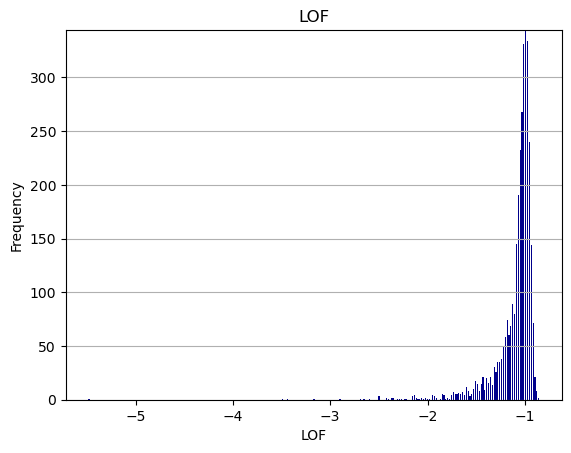

In [130]:
def plot_hist(X: pd.DataFrame, title: str) -> None:
    """ Funcion que genera un grafico de los valores de LOF del dataset """
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.65, color='darkblue')
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))
    
plot_hist(scores, 'LOF')



In [131]:
# Dado el grafico anterior, diremos que un umbral de corte sera aproximadamente -1.85
def lof_threshold(v: float, scores: np.ndarray) -> float:
    ''' Retorna la contaminacion del medio '''
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold 

lof_threshold(-2.5, scores) # Contaminacion del medio



0.0027472527472527475

In [132]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.0027472527472527475)
labels = lof.fit_predict(X.values)

# Obtenemos los indices de los datos que son inliners
indices = list(np.where(labels==1)[0])

# Eliminamos los outliers del dataset 'data', filtrando el dataset solo con los datos
# que no son inliners (label = 1)
X = X.iloc[indices]


In [133]:
print(X.shape)

(3267, 9)


### Clustering
#### Normalization


In [134]:
X_ = MinMaxScaler().fit_transform(X.values)


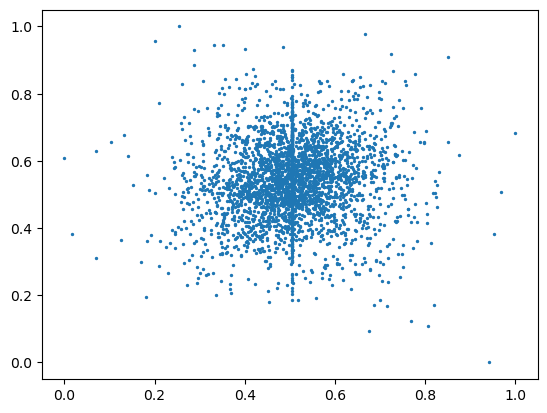

In [135]:
plt.scatter(X_[:, 0], X_[:, 1], s=2)
plt.show()

In [136]:
columns_data = data_cleaned.drop(columns='Potability').columns
columns_data

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')

In [137]:
weights = {
    'Solids': 0.15,
    'Conductivity': 0.15,
    'Turbidity': 0.15,
    'Hardness': 0.15,
    'Sulfate': 0.1,
    'Trihalomethanes': 0.1,
    'Chloramines': 0.1,
    'ph': 0.05,
    'Organic_carbon': 0.05
}
X_df = pd.DataFrame(X_, columns=columns_data)  # replace your_column_names with the actual column names
X_df['contaminationLevel'] = X_df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_df['contaminationLevel'] = scaler.fit_transform(X_df[['contaminationLevel']])
X_df['contaminationLevel'] = X_df['contaminationLevel'].round(1)
X_df['contaminationLevel'].value_counts().sort_index()

/Users/pedro/miniforge3/envs/cv/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/pedro/miniforge3/envs/cv/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


contaminationLevel
0.0       1
0.1       8
0.2     104
0.3     393
0.4     818
0.5    1006
0.6     614
0.7     247
0.8      62
0.9      13
1.0       1
Name: count, dtype: int64

In [138]:
Y = X_df['contaminationLevel']
print(X_.shape, Y.shape)

(3267, 9) (3267,)


In [139]:
umap_2d = UMAP(n_components = 2, min_dist = 1, n_neighbors= 50, n_jobs=8)
X_projection_umap = umap_2d.fit_transform(X_, Y)

In [140]:
def plot_embedding(X,title):
    _, ax = plt.subplots(figsize=(8, 8))

    for digit in np.unique(Y):
        ax.scatter(
            *X[Y == digit].T,
            marker=f"${digit}$",
            color=plt.cm.Dark2(digit),
            alpha=0.3,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 5e-8:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
    ax.set_title(title)
    ax.axis("off")

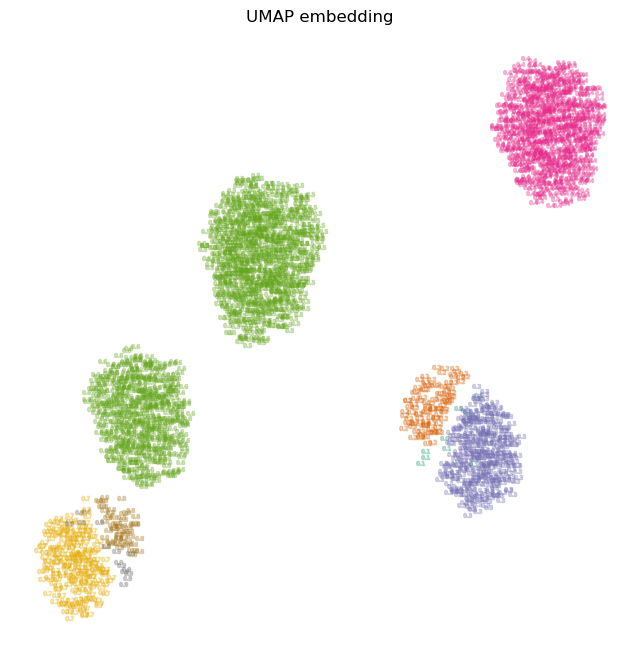

In [141]:
plot_embedding(X_projection_umap, "UMAP embedding")

In [142]:
X_ = X_projection_umap

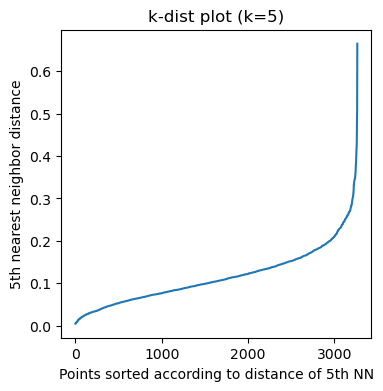

In [143]:
# Kdist para minPts = 5
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_)
distances, indices = neighbors_fit.kneighbors(X_)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(4, 4))
plt.xlabel("Points sorted according to distance of 5th NN")
plt.ylabel("5th nearest neighbor distance")
plt.title("k-dist plot (k=5)")
plt.plot(distances)
plt.show()

In [144]:
# K-dist nos dice que tenemos que usar un eps aprox a 0.6
dbscan = cluster.DBSCAN(eps=0.5, min_samples=6)
model = dbscan.fit(X_)

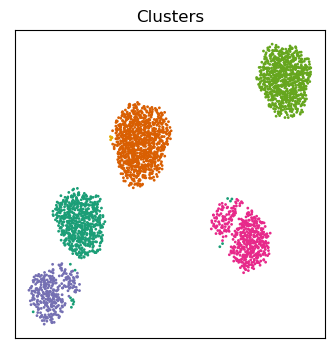

In [145]:
y_pred = model.labels_.astype(int) # en esta parte vemos en qué cluster quedó cada dato

def colour(x):
    return plt.cm.Dark2(x)

colors = list(map(colour,y_pred))

plt.figure(figsize=(4, 4))
plt.title("Clusters")
plt.scatter(X_[:, 0], X_[:, 1], s=1, color=colors)
plt.xticks(())
plt.yticks(())
plt.show()

In [146]:
optics = cluster.OPTICS(min_samples=6, min_cluster_size=0.1)
optics = optics.fit(X_)

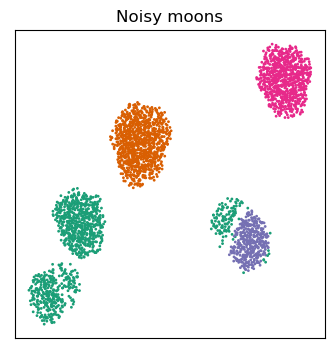

In [147]:
y_pred = optics.labels_.astype(int)

colors = list(map(colour,y_pred))

plt.figure(figsize=(4, 4))
plt.title("Noisy moons")
plt.scatter(X_[:, 0], X_[:, 1], s=1, color=colors)
plt.xticks(())
plt.yticks(())
plt.show()

In [148]:
space = np.arange(len(X_))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

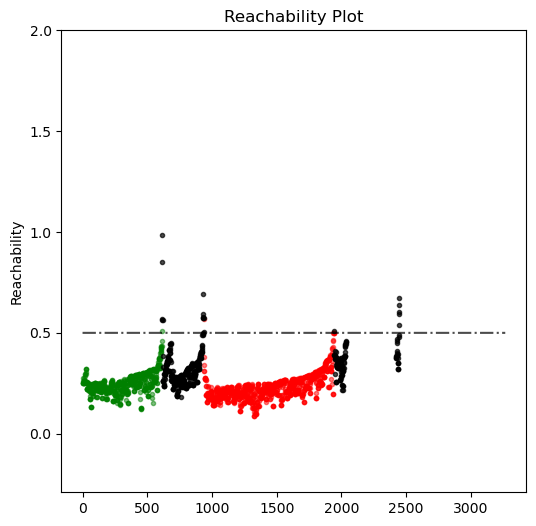

In [149]:
_, ax = plt.subplots(figsize=(6, 6))

# Reachability plot
colors = ["g.", "r."]
for klass, color in zip(range(0, 2), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax.plot(Xk, Rk, color, alpha=0.5)
ax.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.7)
ax.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.7)
ax.set_ylim(top=2)
ax.set_ylabel("Reachability")
ax.set_title("Reachability Plot")
plt.show()

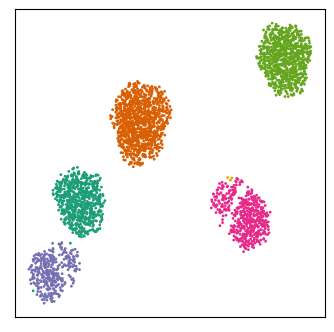

In [150]:
dbscan_2 = cluster.DBSCAN(eps=0.5, min_samples=2)
model = dbscan_2.fit(X_)

y_pred = model.labels_.astype(int) # en esta parte vemos en qué cluster quedó cada dato

def colour(x):
    return plt.cm.Dark2(x)

colors = list(map(colour,y_pred))

plt.figure(figsize=(4, 4))
plt.scatter(X_[:, 0], X_[:, 1], s=1, color=colors)
plt.xticks(())
plt.yticks(())
plt.show()